In [133]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

In [67]:
df = pd.read_csv('NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [68]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [69]:
df["dist_km"] = haversine_distance(df, "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude")
df.head()

df["pickup_datetime"] = pd.to_datetime(df.pickup_datetime)
df["EDTdate"] = df.pickup_datetime - pd.Timedelta(hours=4)
df["hour"] = df["EDTdate"].dt.hour
df["AMorPM"] = np.where(df["hour"] < 12, 'am', 'pm')
df["weekday"] = df["EDTdate"].dt.strftime("%a")

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,hour,AMorPM,weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [90]:
cat_cols = ["hour", "AMorPM", "weekday"]
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']
y_col = ["fare_amount"]

In [91]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [92]:
cats = np.stack([df[cat].cat.codes.values for cat in cat_cols],axis=1)
cats = torch.tensor(cats, dtype=torch.int64)
cats

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        ...,
        [14,  1,  3],
        [ 4,  0,  5],
        [12,  1,  2]])

In [93]:
conts = np.stack([df[cont].values for cont in cont_cols], axis=1 )
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [119]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [120]:
cat_sizes = [ len(df[col].cat.categories) for col in cat_cols]
cat_sizes

[24, 2, 7]

In [121]:
emb_sizes = [(size,min(50,(size +1)//2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [122]:
catz = cats[:2]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [123]:
selfEmbeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
selfEmbeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [124]:
embeddingz = []

for i, e in enumerate(selfEmbeds):
    embeddingz.append(e(catz[:,1]))

embeddingz

[tensor([[-0.7242,  0.3738, -0.0644,  0.0503,  0.4384, -0.7868, -0.3692, -0.4154,
          -0.6299, -0.9473,  1.6961, -1.3462],
         [-0.7242,  0.3738, -0.0644,  0.0503,  0.4384, -0.7868, -0.3692, -0.4154,
          -0.6299, -0.9473,  1.6961, -1.3462]], grad_fn=<EmbeddingBackward0>),
 tensor([[1.0538],
         [1.0538]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.7295,  0.3212,  1.3042, -0.2176],
         [ 0.7295,  0.3212,  1.3042, -0.2176]], grad_fn=<EmbeddingBackward0>)]

In [125]:
z = torch.cat(embeddingz,1)
z

tensor([[-0.7242,  0.3738, -0.0644,  0.0503,  0.4384, -0.7868, -0.3692, -0.4154,
         -0.6299, -0.9473,  1.6961, -1.3462,  1.0538,  0.7295,  0.3212,  1.3042,
         -0.2176],
        [-0.7242,  0.3738, -0.0644,  0.0503,  0.4384, -0.7868, -0.3692, -0.4154,
         -0.6299, -0.9473,  1.6961, -1.3462,  1.0538,  0.7295,  0.3212,  1.3042,
         -0.2176]], grad_fn=<CatBackward0>)

In [126]:
self_emb_drop = nn.Dropout(0.4)
z = self_emb_drop(z)
z

tensor([[-1.2071,  0.0000, -0.1073,  0.0838,  0.7306, -0.0000, -0.0000, -0.6923,
         -0.0000, -0.0000,  0.0000, -2.2437,  1.7563,  0.0000,  0.0000,  0.0000,
         -0.3627],
        [-0.0000,  0.6230, -0.0000,  0.0000,  0.7306, -1.3114, -0.6153, -0.0000,
         -1.0498, -0.0000,  2.8269, -0.0000,  1.7563,  0.0000,  0.5354,  0.0000,
         -0.3627]], grad_fn=<MulBackward0>)

In [127]:
class TabularModel(nn.Module):
    
    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_embs = sum(nf for ni, nf in emb_sizes)
        n_in = n_embs + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_size))
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        
        return x
        
        

In [128]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, conts.shape[1], 1, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [129]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [131]:
batch_size = 60000
test_size = int(batch_size*0.2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

48000

In [135]:
start_time = time.time()

epochs = 300

losses = []

for i in range(epochs):
    i += 1
    
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    if i%10==0:
        print(f'epoch: {i}, loss: {loss}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch: 10, loss: 11.765253067016602
epoch: 20, loss: 11.166104316711426
epoch: 30, loss: 10.764914512634277
epoch: 40, loss: 10.485365867614746
epoch: 50, loss: 10.256299018859863
epoch: 60, loss: 10.048553466796875
epoch: 70, loss: 9.869043350219727
epoch: 80, loss: 9.656042098999023
epoch: 90, loss: 9.436948776245117
epoch: 100, loss: 9.199295043945312
epoch: 110, loss: 8.924463272094727
epoch: 120, loss: 8.611783981323242
epoch: 130, loss: 8.254616737365723
epoch: 140, loss: 7.848959922790527
epoch: 150, loss: 7.4101457595825195
epoch: 160, loss: 6.965509414672852
epoch: 170, loss: 6.505600929260254
epoch: 180, loss: 6.01580810546875
epoch: 190, loss: 5.50617790222168
epoch: 200, loss: 5.058143138885498
epoch: 210, loss: 4.663261413574219
epoch: 220, loss: 4.370302677154541
epoch: 230, loss: 4.120053291320801
epoch: 240, loss: 3.9224464893341064
epoch: 250, loss: 3.897385835647583
epoch: 260, loss: 3.8032078742980957
epoch: 270, loss: 3.802513599395752
epoch: 280, loss: 3.7234375476

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

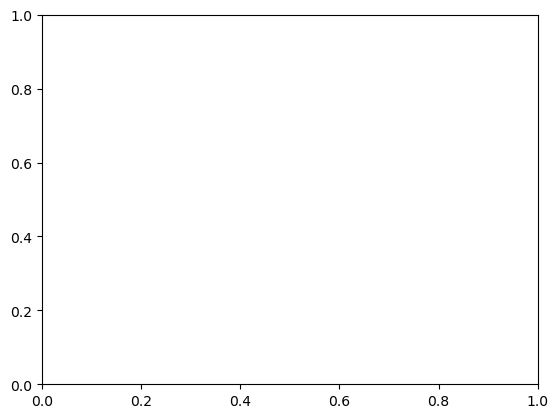

In [137]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');